In [5]:
Update = False

# Simple Bitcoin predictive Model

## Imports & API

### Imports

In [20]:
import json
import time
from tqdm import tqdm

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

#scrap / API
import praw
import requests 

#ARIMA
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

#LSTM RNN
#from keras.models import Sequential
#from keras.layers import Dense, Dropout
#from keras.layers import LSTM

In [3]:
with open('keys.json') as f:
    key = json.loads(f.read())

### BitCoin Market API Fetching & Cleaning

Variables of note: <br>
```c_code``` = Crypto value's code <br>
```c_market``` = Crypto value's market <br>
```c_``` = Cryto value's common name <br>
```crypto.columns = ['open','high','low','close','volume','cap']```

In [118]:
#declaring Fetch parameters
c_code = 'BTC'
c_market = 'USD'

if Update:
    #Fetching Data
    cryptos = requests.get("https://www.alphavantage.co/query?function=DIGITAL_CURRENCY_DAILY&symbol={}&market={}&apikey={}".format(c_code,c_market,key['bit_api_key']))

    #Assigning "name" for ease
    c_ = cryptos.json()['Meta Data']['3. Digital Currency Name']

    #Organizing Data
    crypto = pd.DataFrame.from_dict(cryptos.json()['Time Series (Digital Currency Daily)'],orient='index',dtype='float')
    crypto = crypto.drop(['1b. open (USD)','2b. high (USD)','3b. low (USD)','4b. close (USD)'],axis=1)
    crypto.columns = ['open','high','low','close','volume','cap']
    crypto.index = pd.to_datetime(crypto.index)

    #Cleaning Missing Data
    print("There are {} days between the first and last time stamp, however our API captured {} days.".format(str(crypto.index[-1] - crypto.index[0]).split(" ")[0],len(crypto)))

    if int(str(crypto.index[-1] - crypto.index[0]).split(" ")[0]) - len(crypto) > 5:
        idx = pd.date_range(crypto.index[0], crypto.index[-1])
        crypto = crypto.reindex(idx, fill_value=np.nan)
        print("So we will need to interpolate the {} missing days.".format(crypto.isnull().sum()[0]))
        crypto = crypto.interpolate()
    else:
        print("as such we dont need to interpolate any missing days")

    crypto.to_csv('./Data/Market.csv')

else:
    #will import last fetched csv
    c_ = c_code
    crypto = pd.read_csv('./Data/Market.csv',index_col=0)

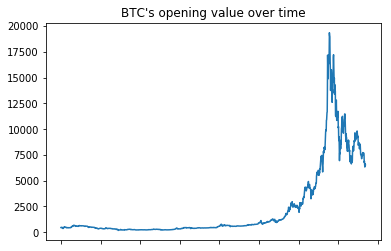

In [120]:
#Sanity Check
crypto.open.plot();
plt.title("{}'s opening value over time".format(c_));

### Reddit API Fetching & Cleaning - WARNING: Reddit updated their API, using old csv

In [91]:
reddit = praw.Reddit(client_id=key["Reddit"]['client_id'],
                     client_secret=key["Reddit"]['client_secret'],
                     password=key["Reddit"]['password'],
                     user_agent=key["Reddit"]['user_agent'],
                     username=key["Reddit"]['username'])

In [92]:
def scrap_time(sub,start=1514764800,end=round(time.time())):
    """
    pulls all subreddit threads from January 1st 2018 (1514764800) 
    until time.now, unless specified
    collects post:
    Title, Score, # of Comments, Post Date, Is_video(boolean)
    """
    funny = reddit.subreddit(sub)
    hot_funny = funny.submissions(start,end)

    funny_list = []
    for submit in tqdm(hot_funny):
        if not submit.stickied:
            fun = {}
            fun['title'] = submit.title
            fun['score'] = submit.score
            fun['comments'] = submit.num_comments
            fun['date'] = datetime.datetime.fromtimestamp(submit.created)
            fun['is_video'] = submit.is_video
            funny_list.append(fun)
    df = pd.DataFrame(funny_list)
    return(df)

In [93]:
#reddit = scrap_time('CryptoCurrency',1521889600)

In [94]:
# #HOT LIMIT 100
# funny_list = []
# for submit in reddit.subreddit('CryptoCurrency').hot(limit=100):
#     fun = {}
#     fun['title'] = submit.title
#     fun['score'] = submit.score
#     fun['comments'] = submit.num_comments
#     fun['date'] = datetime.datetime.fromtimestamp(submit.created)
#     fun['is_video'] = submit.is_video
#     funny_list.append(fun)
# df = pd.DataFrame(funny_list)

In [105]:
reddit = pd.read_csv('./Data/Reddit_Crypto-Copy1.csv')

In [106]:
reddit.title = reddit.title.str.lower()
reddit = reddit.drop('Unnamed: 0',axis=1)
reddit.date = pd.to_datetime(reddit['date']).dt.date

In [111]:
reddit.head()

,comments,date,is_video,score,title
0,1,2018-03-26,False,1,a reminder of all the logical fallacies one sh...
1,0,2018-03-26,False,1,"just filed crypto ""not so like-kind"" exchange ..."
2,0,2018-03-26,False,3,bitmain have developed asic for ethereum - tar...
3,1,2018-03-26,False,2,"shitpost ""investing"" experiment - update"
4,0,2018-03-26,False,1,bringing the fun back to fungibility


In [150]:
#I am only doing the number of comments per day in the cryt subreddit
reddit = pd.DataFrame(reddit.groupby('date')['comments','score'].sum())

In [151]:
reddit.index = pd.to_datetime(reddit.index)

In [152]:
reddit.head()

,comments,score
date,,
2017-10-25,3076,4810
2017-10-26,3146,7692
2017-10-27,4388,6809
2017-10-28,2108,4612
2017-10-29,2089,2507


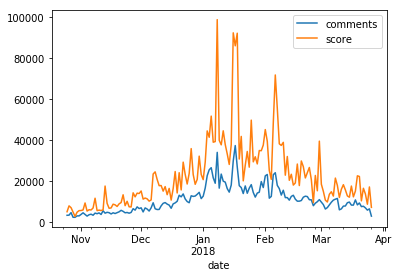

In [153]:
reddit.plot();

In [154]:
#Cleaning Missing Data
print("There are {} days between the first and last time stamp, however our API captured {} days.".format(str(reddit.index[-1] - reddit.index[0]).split(" ")[0],len(reddit)))

if int(str(reddit.index[-1] - reddit.index[0]).split(" ")[0]) - len(reddit) > 5:
    idx = pd.date_range(reddit.index[0], reddit.index[-1])
    reddit = reddit.reindex(idx, fill_value=np.nan)
    print("So we will need to interpolate the {} missing days.".format(reddit.isnull().sum()[0]))
    reddit = reddit.interpolate()
else:
    print("as such we dont need to interpolate any missing days")

There are 152 days between the first and last time stamp, however our API captured 153 days.
as such we dont need to interpolate any missing days


In [155]:
#I will eventually implment a predictor comparing reddit comments with the values
#bit = bit.join(reddit)

In [156]:
bit = crypto 

In [157]:
bit = bit.merge(reddit,left_index=True, right_index=True)

## Preliminary EDA

In [158]:
mm = MinMaxScaler()

In [159]:
bit2 = mm.fit_transform(bit)

In [160]:
bit2 = pd.DataFrame(bit2,columns=bit.columns)

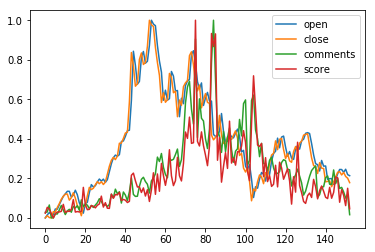

In [165]:
bit2[['open','close','comments','score']].plot()

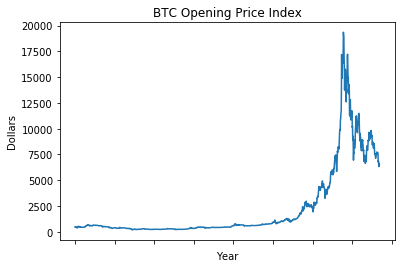

In [121]:
#
crypto.open.plot()
plt.title('{} Opening Price Index'.format(c_))
plt.ylabel('Dollars')
plt.xlabel('Year');

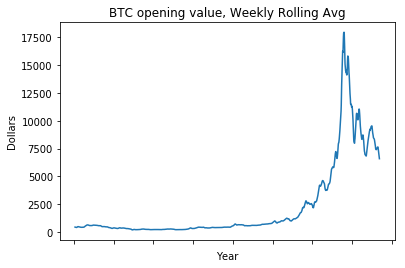

In [122]:
#weekly rolling avg by week
crypto.open.rolling(window=7, center=False).mean().plot()
plt.title('{} opening value, Weekly Rolling Avg'.format(c_code))
plt.ylabel('Dollars')
plt.xlabel('Year');

### Autocorrelation & Partial Autocorrelation

because of how correlated every day's bitcoin value is dependant on the day before,
we look at its autocorrelation.
    - (correlation, to itself)

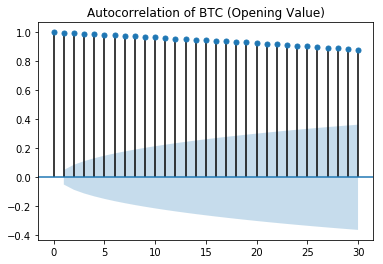

In [123]:
plot_acf(crypto.open, lags=30)
plt.title('Autocorrelation of {} (Opening Value)'.format(c_code));

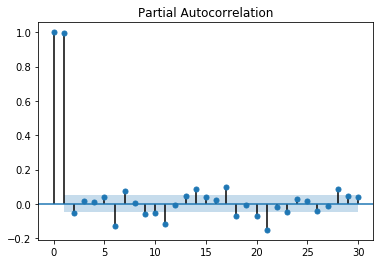

In [124]:
plot_pacf(crypto.open, lags=30);

In [ ]:
#
crypto[crypto.index>'2017-10-25']['open'].plot()
plt.title('{} Price Index (After Oct 25th, 2017)'.format(c_))
plt.ylabel('Dollars')
plt.xlabel('Year');

In [ ]:
"""
bit[bit.index>'2017-10-25']['comments'].plot()
plt.title('BitCoin Reddit Activity (After Oct 25th, 2017)')
plt.ylabel('n Comments')
plt.xlabel('Year');
"""

## Trend, Seasonality & Trend

In [ ]:
result = seasonal_decompose(crypto.open)
result.plot();

Well that looks like a mess, likely due to the amount of time when bitcoin was worthless

Lets look at it when bitcoin became a bit more relivant

In [ ]:
relivant  = crypto[crypto.open.index>'2016-10-27']['open']

In [ ]:
result = seasonal_decompose(relivant)
result.plot();

That looks better, but still a lot of dead time

In [ ]:
more_rel = crypto[crypto.index>='2017-10-25']
seasonal_decompose(more_rel.open).plot();

Much better, well now we can see some clearer trends.

This shows us:
    - a clearer trend over time peaking in late Dec
    - Bitcoin does not seem to be heavily affected by seasonality, only +/- 100
    - Residuals seem to make up the majority of variability, which makes sense consider how  bitcoins have stronger social driving factors rather than seasonal/global

Looking for other predictors of Bitcoin Value:
    - I am curious to see if reddit's cryptocurrency subreddit may be a predictor.

In [ ]:
#bit = bit[bit.index>='2017-10-25']

In [ ]:
#seasonal_decompose(bit.comments).plot();

It looks like the comments are much more affected by seasonality, than the coin's value, however +/- 2000 is still not very much when compared to the noise of 10,000

In [ ]:
seasonal_decompose(more_rel.open).trend.plot()
plt.title('{} Value Trend'.format(c_));

In [ ]:
#seasonal_decompose(bit.comments).trend.plot()
#plt.title('Reddit Activity Trend');

In [ ]:
"""
plt.subplot(211)
seasonal_decompose(more_rel).trend.plot()
plt.title('Bitcoin Value Trend')
plt.subplot(212)
seasonal_decompose(bit.comments).trend.plot()
plt.title('Reddit Activity Trend');
"""

## LSTM RNN

I am sceptical that this NN this will provide much insight, considering our seasonality analysis showed how heavily residuals affect the overall value.

Our target is to predict the value of bitcoin a week from the end of a training set

As to avoid having more weight given to the time during which Bitcoin was worthless.
- I am using the 'more_relivant' time set which is after Oct.25.2017
- The reasoning here is "bitcoin's very low value could be highly due to its nature being unknown to the majority of the public, after that arbitrary point, it became more well known and thus more active"

First our data needs to be scaled before being split
    - Otherwise the values at time n would be not properly scaled to the min and max of the data at time n-

In [ ]:
train = crypto.open[crypto.index<'2018-03-01']
test = crypto.open[crypto.index>='2018-03-01']

In [ ]:
#train = more_rel.open[more_rel.index<'2018-02-01']
#test = more_rel.open[more_rel.index>='2018-02-01']

In [ ]:
#NN need values between 0-1
mm = MinMaxScaler()

#preprocessing
#mm scaler needs atleast a 2D array
train = np.reshape(train.values, (len(train), 1))
train = mm.fit_transform(train)

#here we are predicting Q days ahead
Q = 7
X_train = train[0:len(train)-Q]
y_train = train[Q:len(train)]

#RNN again, needs reshaping
#the shaping choices were picked for if I want to use a multi-dim training
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

In [ ]:
def model(X_train, y_train, dropout= 0.1, batch_size = 16, lstm_units = 7, activation = 'relu'):
    # Initialising the RNN
    regressor = Sequential()
    
    # Adding the input layer and the LSTM layer
    regressor.add(LSTM(units = lstm_units, activation = activation, input_shape = (None, 1)))
    regressor.add(Dropout(dropout))
    
    # Adding the output layer
    regressor.add(Dense(units = 1))

    # Compiling the RNN
    regressor.compile(optimizer = 'adam', loss = 'mae')

    # Fitting the RNN to the Training set
    regressor.fit(X_train, y_train, batch_size = batch_size, epochs = 10,verbose=0)
    return(regressor)

In [ ]:
regressor = model(X_train,y_train)

In [ ]:
# Making the predictions
test_set = test.values

#reshape for scaling
val = np.reshape(test_set, (len(test_set), 1))
val = mm.transform(val)

#reshaped for NN
val = np.reshape(val, (len(val), 1, 1))
predicted_BTC_price = regressor.predict(val)
predicted_BTC_price = mm.inverse_transform(predicted_BTC_price)[:,0]

In [ ]:
pred = pd.DataFrame({'True':test_set,'Pred':predicted_BTC_price},index=test.index)

In [ ]:
pred.plot()
plt.title('BitCoin True vs Pred')
plt.ylabel('Value')
plt.xlabel('Date');

- This likely tells us that for the most part the NN assumes the value of bitcoin will remain more stable than it usually does (considering bitcoin's volitile nature)
- This can be remedied by:
    - Increasing the # of feature by which it is calculating the values
    - Adjust the memory that the NN fetchs from in the LSTM cells
    - Train more
        - the fear with that comes from overfitting to pre-existing trends which would ultimately do no more than say 'the score is basically yesterday's score'

## ARIMA

Lets go back to more traditional forcasting models

In [ ]:
season = seasonal_decompose(more_rel.open)
season.plot();

In [ ]:
#It looks like the variation may align with weeks
season.seasonal[68:99].plot();

In [ ]:
first_m = pd.DataFrame({"season":season.seasonal})

In [ ]:
first_m['day'] = first_m.index.weekday_name

In [ ]:
first_m.groupby('day')['season'].mean()

In [ ]:
#Again huge imact
#It would be interesting to scrape the news/twitter/reddit 
#for what may have been a predictor for any underlying trends in these residuals
season.resid.plot();

In [ ]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    # Determining rolling statistics:
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    # Plotting rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    # Performing a Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    print(dfoutput )

### Seasonal Difference

In [ ]:
S_ana = more_rel

In [ ]:
#so reminder this is our data
more_rel.open.head()

In [ ]:
#remember we are paying attention to when bitcoin was relivant, 'more_rel' is a numpy array
#more_rel = bit[bit.index>='2017-10-25']

In [ ]:
#let us check and see how stationary the data is, so we can gather what we can from it
test_stationarity(S_ana.open)

Unsurprising, the values alone are NOT stationary, because it hasn't be adjusted for

Let us look at the differences by the day

In [ ]:
S_ana.open.diff(1).plot();

Let us check how stationary the data is

In [ ]:
test_stationarity(S_ana.open)

Well those map VERY heavily, because its the constant difference to the last value, so yeah it appears that the differences are stationary but that doesnt mean too much

Does finding the difference by the season AS well as the day improve things?

In [ ]:
#.diff(1) = diff by the day
#.diff(12) = diff by the months in year

test_stationarity(S_ana.open.diff(2).dropna())

Not dramatically

In [ ]:
#by day   - diff(1)
#by week  - diff(7)

test_stationarity(S_ana.open.diff(1).diff(7).diff(12).dropna())

In [ ]:
#by day   - diff(1)
#by week  - diff(7)
#by month - diff(12)
#by hour  - diff(24)

#there are no more real valid ways to seperate, 
#this is not particularly useful because the values are so decomposed. 
#so this is purly for experimental purposes

test_stationarity(S_ana.open.diff(1).diff(24).diff(7).diff(12).dropna())

In [ ]:
rr = S_ana.open.diff(2).dropna()

In [ ]:
from statsmodels.tsa.arima_model import ARIMA, ARMA

train_2 =  rr.head(len(rr)-21)
test_2 = rr.tail(21)

model = ARMA(train_2, (2,1)).fit()
model.summary()

- Wow that model did not do well

- Lets see if we can find something better with a gridsearch
    - there will be a lot of impossible combinations, hense the 'try' params

In [ ]:
arima_parameters = {"d":[0,1,2,3,4,5,6,7],
                    "p":[0,1,2,3,4,5,6,7],
                    "q":[0,1,2,3,4,5,6,7]}

In [ ]:
from tqdm import tqdm

In [ ]:
aic_0 = {}
for d in tqdm(arima_parameters['d']):
    for p in tqdm(arima_parameters['p']):
        for q in arima_parameters['q']:
            try:
                AR2MA = ARIMA(train_2, (p,d,q)).fit();
                params = str('|d:{}|p:{}|q:{}|'.format(d,p,q));
                aic_0[params] = AR2MA.aic;
            except:
                continue

In [ ]:
aic_0

In [ ]:
train_2.plot()

In [ ]:
import seaborn as sns

In [ ]:
ax = sns.barplot(x=['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun'], 
            y=rel.bpi.groupby(rel.index.dayofweek).sum())
ax.set_title('Frequency of Posts by Time of Day')
ax.set_xlabel('Hour of the day')
ax.set_ylabel('Sum of Posts');
plt.ylim(220000, 233000);